# STP 494 Project 2- Building a Churn Model to Classify Bank Customers

Author: Sam Steinberg, Computer Science Student- Arizona State University

A very useful application of machine learning is being able to predict the churn of customers. It is useful for any company to understand their customer data in order to specify which potential clients to target and who not to. The goal of this project is to build a classifier that can predict whether a customer will stay or leave their bank based on certain independent variables.

In [176]:
#Importing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

## Step 1- Data Preprocessing

I used a bank customer dataset from Kaggle [1]. I chose this dataset since has a decent sample size (10,000 customers), has little to no NA values and contains data that most banks would likely have available to them. 

In [177]:
#Loading in dataset.
dataset = pd.read_csv("Churn_Modeling.csv")

#Getting rid of any NA values in the dataset
dataset.dropna()

#Getting rid of obviously useless columns (Row Number, Customer ID, Name)
dataset.drop(dataset.columns[[0,1,2]], axis = 1, inplace = True)
dataset

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Seeing how many customers exited the bank to make sure our sample size is sufficient. Since only 25% of customers exited the bank, I will make class weights balanced in the model [2].

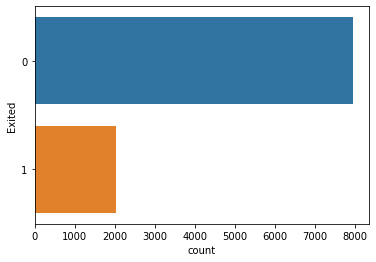

In [178]:
sns.countplot(y = "Exited", data = dataset)
plt.show()

I am making sure we do not have multicollinearity between independent variables, which it doesn't look like we do. I am also seeing which variables more strongly influence our dependent variable.

It appears Credit Score, Gender, and Tenure made the model less accurate, so they will be removed from the model. As you can see from the graph, their deep purple color means they do not have a lot of correlation with "Exited", our dependent variable.

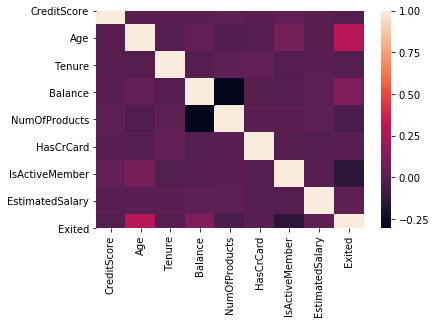

In [179]:
sns.heatmap(dataset.corr())
plt.show()

In [180]:
#Getting rid of independent variables that are not useful to the model (have low correlation with our dependent variable)
dataset.drop(dataset.columns[[0,2,4]], axis = 1, inplace = True)
dataset

,Geography,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,France,42,0.00,1,1,1,101348.88,1
1,Spain,41,83807.86,1,0,1,112542.58,0
2,France,42,159660.80,3,1,0,113931.57,1
3,France,39,0.00,2,0,0,93826.63,0
4,Spain,43,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...
9995,France,39,0.00,2,1,0,96270.64,0
9996,France,35,57369.61,1,1,1,101699.77,0
9997,France,36,0.00,1,0,1,42085.58,1
9998,Germany,42,75075.31,2,1,0,92888.52,1


In [181]:
#Splitting Dataset into dependent and independent variables
x = dataset.iloc[:,:7].values
y = dataset.iloc[:,7].values

#Encoding Categorical Variables
le = LabelEncoder()
x[:,(0)] = le.fit_transform(x[:,(0)])

In [182]:
#Splitting Data into training and test sets
#I found a test set size of 15% gave the best results
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.15, random_state = 0) 

In [183]:
#Feature Scaling our variables so they are normalized for the model
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Step 2- Building and Fitting Model

I tested numerous classifiers to see which gave the most accurate results and RandomForest came out on top. I found using 100 estimators and a balanced class weight gave the most accurate results

In [184]:
model = RandomForestClassifier(n_estimators= 100, class_weight = 'balanced', criterion = 'entropy', random_state = 0)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [185]:
#Predicting whether a customer stayed or left the bank
yPred = model.predict(x_test)

## Step 3- Evaluating Model Performance

I calculated the accuracy score as the first criteria in evaluating model performance. It determines how many values (0 or 1), our model correctly predicted for the test set. This value was 85.4%. In other words the model predicted 85.4% of customer outcomes correctly.

In [186]:
accuracy_score(y_test,yPred)

0.854

Solely using the accuracy score to evaluate model performance can be misleading [3]. I now calculate Precision, Recall, and F1-Score for further analysis. I found my model is very accurate in predicting which customers would stay with the bank (f1-score of 0.91). It is weaker when predicting customers who will leave the bank (F1-score 0.61). A higher sample size for exited customers would likely improve model performance.

In [187]:
print(classification_report(y_test,yPred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1194
           1       0.67      0.55      0.61       306

    accuracy                           0.85      1500
   macro avg       0.78      0.74      0.76      1500
weighted avg       0.85      0.85      0.85      1500



I used a confusion matrix to determine how many false positives, true positives, false negative, and true negatives our model attained [3]. As you can see, our model was weaker when predicting those customers who left the bank, but was very accurate for those customers who stayed. This supports the findings from the classification report above.

In [188]:
cm = confusion_matrix(y_test,yPred)
cm

array([[1113,   81],
       [ 138,  168]])

Another tool in evaluating model performance is using an AUC graph [3]. The closer the line gets to y=1, the more accurate the model is. Our AUC score is .738. AUC scores vary from 0to 1, with 0.5 being a poor model and 1 being a perfect model. Our model is respectable (AUC > .70), but has room for improvement. A higher sample size of customers who left the bank would improve this score. 

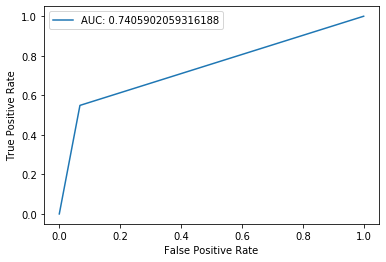

In [189]:
#Visualizing Results with AUC Graph in order to evaluate model performance
fpr,tpr,threshold = roc_curve(y_test, yPred)
auc = auc(fpr,tpr)

plt.plot(fpr,tpr, label = 'AUC: ' + str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Conclusion

I used the Random Forest classifier to predict whether a certain customer would leave their bank or stay. My model predicted the correct outcome 85.4% of the time for the test set data. I improved the model by testing other classifier like logistic regression, and removing independent variables that had very low correlation with our dependent variable. Using F1-scores to evaluate accuracy, I ran dozens of models with different combinations of independent variables to determine which variables were less important. I found that gender, credit score, and tenure of the customer were not effective in predicting whether they would stay or leave the bank. This is a very interesting find since one would intuitively expect the tenure of a customer to be an influencing factor. 

Providing they have sufficient data, a bank can use my model to help them figure out which of their customers will soon leave, and who to target when evaluating potential clients. This once again displays the power of machine learning and how powerful it can be in a variety of classification and other problems. 

## References

[1] Shruti_Iyyer. “Churn Modelling.” Kaggle, 3 Apr. 2019, www.kaggle.com/shrutimechlearn/churn-modelling.

[2] Koehrsen, Will. “Hyperparameter Tuning the Random Forest in Python.” Medium, Towards Data Science, 10 Jan. 2018, towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74.

[3] 
Dey, Ishaan. “Evaluating Classification Models.” Medium, Towards Data Science, 14 June 2019, towardsdatascience.com/hackcvilleds-4636c6c1ba53.